# Fishtest SPRT optimization

In [20]:
from pylab import *

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Basic SPRT definitions

convert between logistic and Bayes elo

In [22]:
def scale(draw_elo):
    return 4*10.0**(-draw_elo/400.0)/(1+10.0**(-draw_elo/400.0))**2

basic sprt pass probability (quick form)

In [23]:
def sprt_pass_prob(x, draw_elo, elo0, elo1, conf):
    return 1/(1+exp(log(conf)*(2*x/scale(draw_elo)-elo0-elo1)/(elo1-elo0)))

## Fishtest test models
Using measured draw_elo for STC (226) and LTC (288), all using confidence levels p = 0.05.

### current state
Fishtest test probabilities for current [0,5] bounds, including multiple STC tries.
Speculative/direct LTC implies using ltc pass probability only.

In [24]:
def stc_now(x):
    return sprt_pass_prob(x, 226.0, 0.0, 5.0, 0.05)

def ltc_now(x):
    return sprt_pass_prob(x, 288.0, 0.0, 5.0, 0.05)

def combined_stc_ltc_now(x, ntries):
    stcPass = 0
    for i in range(ntries):
        stcPass = stcPass + stc_now(x) * (1 - stc_now(x))**i
    return ltc_now(x) * stcPass


In [25]:
x = np.linspace(0, 5, 1000)
dx = x[1]-x[0]

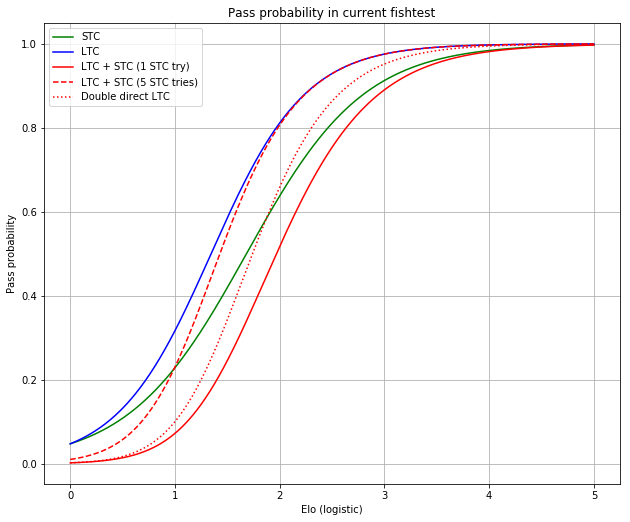

In [26]:


stcvals_now = [stc_now(e) for e in x]
ltcvals_now = [ltc_now(e) for e in x]
combinedvals1_now = [combined_stc_ltc_now(e, 1) for e in x]
combinedvals5_now = [combined_stc_ltc_now(e, 5) for e in x]
doubleDirectvals_now = [ltc_now(e)**2 for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Pass probability in current fishtest')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Pass probability')
axes.plot(x, stcvals_now, label = 'STC', color = 'g')
axes.plot(x, ltcvals_now, label = 'LTC', color = 'b')
axes.plot(x, combinedvals1_now, label = 'LTC + STC (1 STC try)', color = 'r')
axes.plot(x, combinedvals5_now, label = 'LTC + STC (5 STC tries)', color = 'r', ls = '--')
axes.plot(x, doubleDirectvals_now, label = 'Double direct LTC', color = 'r', ls = ':')
axes.grid()
axes.legend()

### proposed state
Proposed settings, insert proposed bounds here

In [27]:
def stc_prop(x):
    return sprt_pass_prob(x, 226.0, -1.0, 2.0, 0.05)

def ltc_prop(x):
    return sprt_pass_prob(x, 288.0, 0.5, 3.5, 0.05)

def combined_stc_ltc_prop(x, ntries):
    stcPass = 0
    for i in range(ntries):
        stcPass = stcPass + stc_prop(x) * (1 - stc_prop(x))**i
    return ltc_prop(x) * stcPass

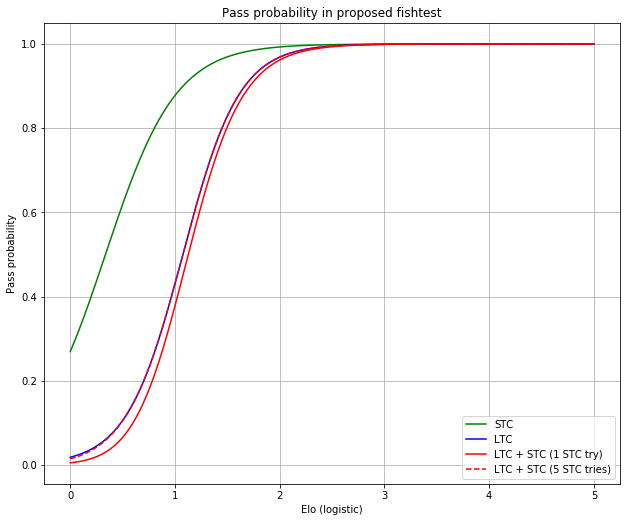

In [28]:


stcvals_prop = [stc_prop(e) for e in x]
ltcvals_prop = [ltc_prop(e) for e in x]
combinedvals1_prop = [combined_stc_ltc_prop(e, 1) for e in x]
combinedvals5_prop = [combined_stc_ltc_prop(e, 5) for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Pass probability in proposed fishtest')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Pass probability')
axes.plot(x, stcvals_prop, label = 'STC', color = 'g')
axes.plot(x, ltcvals_prop, label = 'LTC', color = 'b')
axes.plot(x, combinedvals1_prop, label = 'LTC + STC (1 STC try)', color = 'r')
axes.plot(x, combinedvals5_prop, label = 'LTC + STC (5 STC tries)', color = 'r', ls = '--')
axes.grid()
axes.legend()

## Fishtest patch models
assume some simple model for the distribution of created patches. It is necessarily an approximation. The precise shape of the distribution doesn't really matter for tests with high (> ~5 Elo) or low (< ~0 Elo). The measurement on fishtest is available. ![](stc_tests_elo.png)

In [29]:
def patch_elo_dist(x):
    sigma = 0.85
    mu = 0.56
    return exp(-0.5*((x-mu)/sigma)**2)/(sqrt(2*pi)*sigma)

## Comparison current vs. proposed
### pass probabilities

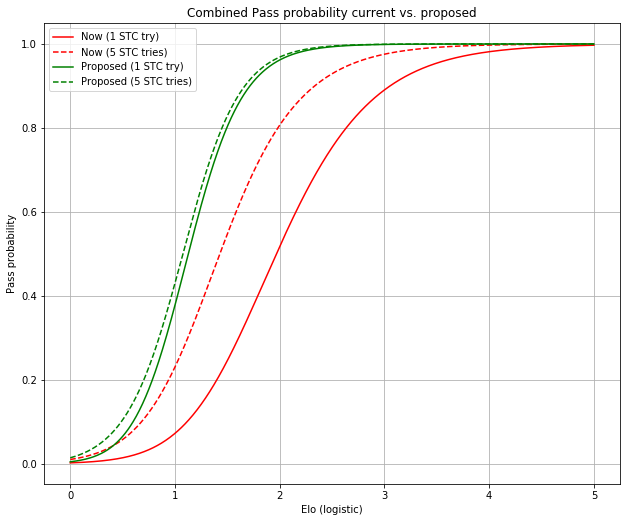

In [30]:
fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Combined Pass probability current vs. proposed')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Pass probability')
axes.plot(x, combinedvals1_now, label = 'Now (1 STC try)', color = 'r')
axes.plot(x, combinedvals5_now, label = 'Now (5 STC tries)', color = 'r', ls = '--')
axes.plot(x, combinedvals1_prop, label = 'Proposed (1 STC try)', color = 'g')
axes.plot(x, combinedvals5_prop, label = 'Proposed (5 STC tries)', color = 'g', ls = '--')
axes.grid()
axes.legend()

## Influence of testing on patch distribution
### without elo weighting.
surface under the graph is proportional to the number of applied patches

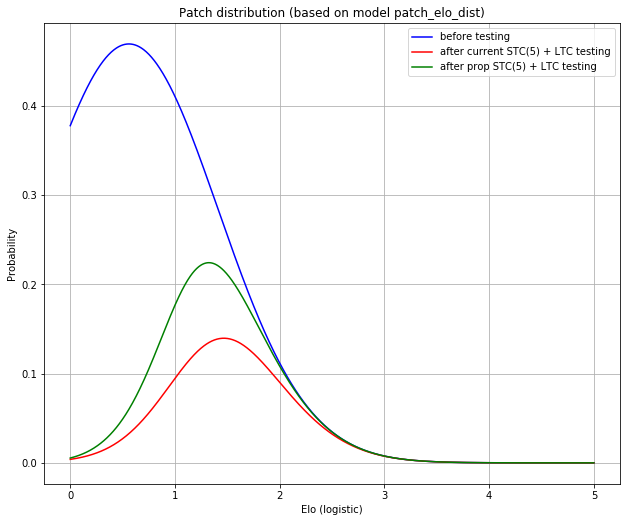

In [31]:
patchelovals = [patch_elo_dist(e) for e in x]
patchelovals_now = [patch_elo_dist(e)*combined_stc_ltc_now(e, 5) for e in x]
patchelovals_prop = [patch_elo_dist(e)*combined_stc_ltc_prop(e, 5) for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Patch distribution (based on model patch_elo_dist)')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Probability')
axes.plot(x, patchelovals, label = 'before testing', color = 'b')
axes.plot(x, patchelovals_now, label = 'after current STC(5) + LTC testing', color = 'r')
axes.plot(x, patchelovals_prop, label = 'after prop STC(5) + LTC testing', color = 'g')
axes.grid()
axes.legend()

### with elo weighting
surface under the graph is elo contribution to the code

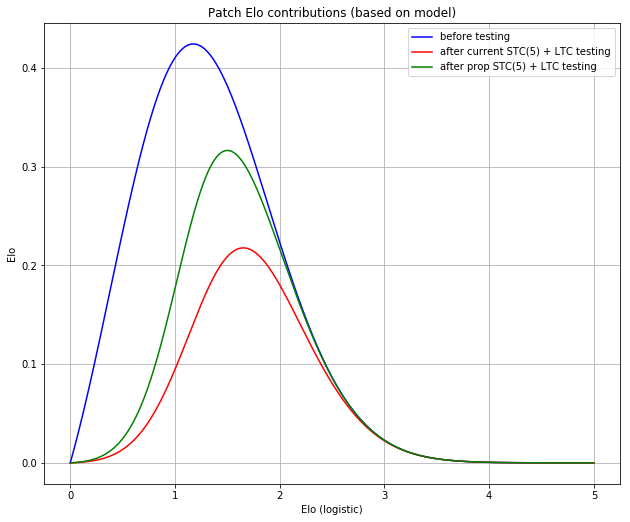

In [32]:
epatchelovals = [e*patch_elo_dist(e) for e in x]
epatchelovals_now = [e*patch_elo_dist(e)*combined_stc_ltc_now(e, 5) for e in x]
epatchelovals_prop = [e*patch_elo_dist(e)*combined_stc_ltc_prop(e, 5) for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Patch Elo contributions (based on model)')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Elo')
axes.plot(x, epatchelovals, label = 'before testing', color = 'b')
axes.plot(x, epatchelovals_now, label = 'after current STC(5) + LTC testing', color = 'r')
axes.plot(x, epatchelovals_prop, label = 'after prop STC(5) + LTC testing', color = 'g')
axes.grid()
axes.legend()

### Summary statistics

#### Number of patches

In [33]:
sum(patchelovals_now) / sum(patchelovals) # Fraction of patches (out of shown range) applied (currently)

0.26467741703120312

In [34]:
sum(patchelovals_prop) / sum(patchelovals) # Fraction of patches (out of shown range) applied (proposed)

0.39704715945638874

In [35]:
sum(patchelovals_prop) / sum(patchelovals_now) # ratio of the number of patches applied

1.5001172518227361

#### Elo gain of accepted patches

In [36]:
sum(epatchelovals_now) / sum(epatchelovals) # Elo fraction accepted now

0.43849196529961376

In [37]:
sum(epatchelovals_prop) / sum(epatchelovals) # Elo fraction accepted proposal

0.61465187595679649

In [38]:
sum(epatchelovals_prop) / sum(epatchelovals_now) # ratio of elo increase

1.4017403387011111

#### Cost estimate
Todo